In [1]:
!nvidia-smi

Wed Oct  2 11:37:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.13                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              6W /   60W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

torch.cuda.is_available()

True

<br><br><br><br>

## Training Model

In [3]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [4]:
MODEL_ARCH = "yolo_nas_m"
BATCH_SIZE = 4
MAX_EPOCHS = 25

HOME="C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model"
EXPERIMENT_NAME="yolonas-m-model-1--20epoch"
CHECKPOINT_DIR = f'{HOME}/checkpoints'


<br>

In [5]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

The console stream is logged into C:\Users\sirom\sg_logs\console.log


[2024-09-28 09:17:07] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
W0928 09:17:08.298000 10056 torch\distributed\elastic\multiprocessing\redirects.py:28] NOTE: Redirects are currently not supported in Windows or MacOs.


[WARNING]No module named 'pycocotools'


[2024-09-28 09:17:18] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


<br>

In [6]:
# Dataset , Label information
dataset_params = {
    'data_dir': "C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/dataset",
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'classes': ['futbol', 'player', 'referree'] # labels here 
}

In [7]:

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)


   

[2024-09-28 09:17:47] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 114/114 [00:02<00:00, 41.74it/s]
[2024-09-28 09:17:50] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:  55%|█████▍    | 18/33 [00:00<00:00, 55.90it/s]

Indexing dataset annotations: 100%|██████████| 33/33 [00:00<00:00, 56.22it/s]


In [8]:
train_data.dataset.transforms

<br><br>

In [9]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

[2024-09-28 09:17:57] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-09-28 09:17:57] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-09-28 09:17:57] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


In [12]:

from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,

    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision":  False , # TRUE BY DEFAULT , depending to GPU setting this to True might cause nan value problem in metrics
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50',
    
}

<br>

In [13]:

trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

[2024-09-28 09:20:56] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240928_092056_925759`
[2024-09-28 09:20:56] INFO - sg_trainer.py - Checkpoints directory: C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759
[2024-09-28 09:20:57] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759/console_Sep28_09_20_56.txt


c:\Users\sirom\miniconda3\envs\yolonas-env\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
c:\Users\sirom\miniconda3\envs\yolonas-env\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
c:\Users\sirom\miniconda3\envs\yolonas-env\lib\site-packages\super_gradients\training\sg_trainer\sg_trainer.py:1753: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is depre

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.1458
│   ├── Ppyoloeloss/loss_iou = 0.8326
│   ├── Ppyoloeloss/loss_dfl = 0.5287
│   └── Ppyoloeloss/loss = 3.5071
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.1616
    ├── Ppyoloeloss/loss_iou = 0.7668
    ├── Ppyoloeloss/loss_dfl = 0.4487
    ├── Ppyoloeloss/loss = 3.3772
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0042
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.0



Validating epoch 1: 100%|██████████| 9/9 [00:19<00:00,  2.16s/it]
[2024-09-28 09:23:56] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:23:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.2934878170490265


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0757
│   │   ├── Epoch N-1      = 2.1458 (↘ -1.0701)
│   │   └── Best until now = 2.1458 (↘ -1.0701)
│   ├── Ppyoloeloss/loss_iou = 0.6513
│   │   ├── Epoch N-1      = 0.8326 (↘ -0.1813)
│   │   └── Best until now = 0.8326 (↘ -0.1813)
│   ├── Ppyoloeloss/loss_dfl = 0.4402
│   │   ├── Epoch N-1      = 0.5287 (↘ -0.0885)
│   │   └── Best until now = 0.5287 (↘ -0.0885)
│   └── Ppyoloeloss/loss = 2.1672
│       ├── Epoch N-1      = 3.5071 (↘ -1.34)
│       └── Best until now = 3.5071 (↘ -1.34)
└── Validation
    ├── Ppyoloeloss/loss_cls = 6.9056
    │   ├── Epoch N-1      = 2.1616 (↗ 4.744)
    │   └── Best until now = 2.1616 (↗ 4.744)
    ├── Ppyoloeloss/loss_iou = 0.4732
    │   ├── Epoch N-1      = 0.7668 (↘ -0.2936)
    │   └── Best until now = 0.7668 (↘ -0.2936)
    ├── Ppyoloeloss/loss_dfl = 0.3591
    │   ├── Epoch N-1      = 0.4487 (↘ -0.0896)
    │   └── Best until now = 0.4487 (↘ -0.0896)
    ├── Ppyoloeloss/loss = 7.7

Validating epoch 2: 100%|██████████| 9/9 [00:18<00:00,  2.08s/it]
[2024-09-28 09:25:05] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:25:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4542687237262726


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8411
│   │   ├── Epoch N-1      = 1.0757 (↘ -0.2346)
│   │   └── Best until now = 1.0757 (↘ -0.2346)
│   ├── Ppyoloeloss/loss_iou = 0.5653
│   │   ├── Epoch N-1      = 0.6513 (↘ -0.086)
│   │   └── Best until now = 0.6513 (↘ -0.086)
│   ├── Ppyoloeloss/loss_dfl = 0.4096
│   │   ├── Epoch N-1      = 0.4402 (↘ -0.0306)
│   │   └── Best until now = 0.4402 (↘ -0.0306)
│   └── Ppyoloeloss/loss = 1.816
│       ├── Epoch N-1      = 2.1672 (↘ -0.3511)
│       └── Best until now = 2.1672 (↘ -0.3511)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3447
    │   ├── Epoch N-1      = 6.9056 (↘ -5.561)
    │   └── Best until now = 2.1616 (↘ -0.817)
    ├── Ppyoloeloss/loss_iou = 0.4535
    │   ├── Epoch N-1      = 0.4732 (↘ -0.0197)
    │   └── Best until now = 0.4732 (↘ -0.0197)
    ├── Ppyoloeloss/loss_dfl = 0.3486
    │   ├── Epoch N-1      = 0.3591 (↘ -0.0105)
    │   └── Best until now = 0.3591 (↘ -0.0105)
    ├── Ppyoloeloss/loss = 

Validating epoch 3: 100%|██████████| 9/9 [00:19<00:00,  2.15s/it]
[2024-09-28 09:26:14] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:26:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5496118068695068


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.784
│   │   ├── Epoch N-1      = 0.8411 (↘ -0.0571)
│   │   └── Best until now = 0.8411 (↘ -0.0571)
│   ├── Ppyoloeloss/loss_iou = 0.5502
│   │   ├── Epoch N-1      = 0.5653 (↘ -0.0152)
│   │   └── Best until now = 0.5653 (↘ -0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.3898
│   │   ├── Epoch N-1      = 0.4096 (↘ -0.0198)
│   │   └── Best until now = 0.4096 (↘ -0.0198)
│   └── Ppyoloeloss/loss = 1.724
│       ├── Epoch N-1      = 1.816  (↘ -0.092)
│       └── Best until now = 1.816  (↘ -0.092)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7477
    │   ├── Epoch N-1      = 1.3447 (↘ -0.597)
    │   └── Best until now = 1.3447 (↘ -0.597)
    ├── Ppyoloeloss/loss_iou = 0.4644
    │   ├── Epoch N-1      = 0.4535 (↗ 0.0109)
    │   └── Best until now = 0.4535 (↗ 0.0109)
    ├── Ppyoloeloss/loss_dfl = 0.3516
    │   ├── Epoch N-1      = 0.3486 (↗ 0.0029)
    │   └── Best until now = 0.3486 (↗ 0.0029)
    ├── Ppyoloeloss/loss = 1.563

Validating epoch 4: 100%|██████████| 9/9 [00:17<00:00,  1.99s/it]
[2024-09-28 09:27:27] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:27:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6328052282333374


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7593
│   │   ├── Epoch N-1      = 0.784  (↘ -0.0247)
│   │   └── Best until now = 0.784  (↘ -0.0247)
│   ├── Ppyoloeloss/loss_iou = 0.538
│   │   ├── Epoch N-1      = 0.5502 (↘ -0.0122)
│   │   └── Best until now = 0.5502 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.3837
│   │   ├── Epoch N-1      = 0.3898 (↘ -0.0061)
│   │   └── Best until now = 0.3898 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.681
│       ├── Epoch N-1      = 1.724  (↘ -0.0429)
│       └── Best until now = 1.724  (↘ -0.0429)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6901
    │   ├── Epoch N-1      = 0.7477 (↘ -0.0575)
    │   └── Best until now = 0.7477 (↘ -0.0575)
    ├── Ppyoloeloss/loss_iou = 0.4458
    │   ├── Epoch N-1      = 0.4644 (↘ -0.0186)
    │   └── Best until now = 0.4535 (↘ -0.0077)
    ├── Ppyoloeloss/loss_dfl = 0.3457
    │   ├── Epoch N-1      = 0.3516 (↘ -0.0059)
    │   └── Best until now = 0.3486 (↘ -0.0029)
    ├── Ppyoloeloss/loss

Validating epoch 5: 100%|██████████| 9/9 [00:19<00:00,  2.13s/it]
[2024-09-28 09:28:41] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:28:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8085324168205261


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7204
│   │   ├── Epoch N-1      = 0.7593 (↘ -0.0389)
│   │   └── Best until now = 0.7593 (↘ -0.0389)
│   ├── Ppyoloeloss/loss_iou = 0.5393
│   │   ├── Epoch N-1      = 0.538  (↗ 0.0013)
│   │   └── Best until now = 0.538  (↗ 0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.3908
│   │   ├── Epoch N-1      = 0.3837 (↗ 0.0071)
│   │   └── Best until now = 0.3837 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.6506
│       ├── Epoch N-1      = 1.681  (↘ -0.0305)
│       └── Best until now = 1.681  (↘ -0.0305)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6854
    │   ├── Epoch N-1      = 0.6901 (↘ -0.0047)
    │   └── Best until now = 0.6901 (↘ -0.0047)
    ├── Ppyoloeloss/loss_iou = 0.4699
    │   ├── Epoch N-1      = 0.4458 (↗ 0.0241)
    │   └── Best until now = 0.4458 (↗ 0.0241)
    ├── Ppyoloeloss/loss_dfl = 0.3526
    │   ├── Epoch N-1      = 0.3457 (↗ 0.0069)
    │   └── Best until now = 0.3457 (↗ 0.0069)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 6: 100%|██████████| 9/9 [00:18<00:00,  2.11s/it]
[2024-09-28 09:29:54] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:29:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.85733562707901


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7135
│   │   ├── Epoch N-1      = 0.7204 (↘ -0.0069)
│   │   └── Best until now = 0.7204 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.5356
│   │   ├── Epoch N-1      = 0.5393 (↘ -0.0038)
│   │   └── Best until now = 0.538  (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.387
│   │   ├── Epoch N-1      = 0.3908 (↘ -0.0038)
│   │   └── Best until now = 0.3837 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.6361
│       ├── Epoch N-1      = 1.6506 (↘ -0.0145)
│       └── Best until now = 1.6506 (↘ -0.0145)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.634
    │   ├── Epoch N-1      = 0.6854 (↘ -0.0514)
    │   └── Best until now = 0.6854 (↘ -0.0514)
    ├── Ppyoloeloss/loss_iou = 0.4639
    │   ├── Epoch N-1      = 0.4699 (↘ -0.006)
    │   └── Best until now = 0.4458 (↗ 0.0181)
    ├── Ppyoloeloss/loss_dfl = 0.3493
    │   ├── Epoch N-1      = 0.3526 (↘ -0.0033)
    │   └── Best until now = 0.3457 (↗ 0.0036)
    ├── Ppyoloeloss/loss = 1

Validating epoch 7: 100%|██████████| 9/9 [00:19<00:00,  2.12s/it]
[2024-09-28 09:31:08] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:31:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8719108700752258


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7071
│   │   ├── Epoch N-1      = 0.7135 (↘ -0.0064)
│   │   └── Best until now = 0.7135 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.5278
│   │   ├── Epoch N-1      = 0.5356 (↘ -0.0077)
│   │   └── Best until now = 0.5356 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.3886
│   │   ├── Epoch N-1      = 0.387  (↗ 0.0015)
│   │   └── Best until now = 0.3837 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.6235
│       ├── Epoch N-1      = 1.6361 (↘ -0.0126)
│       └── Best until now = 1.6361 (↘ -0.0126)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6339
    │   ├── Epoch N-1      = 0.634  (↘ -1e-04)
    │   └── Best until now = 0.634  (↘ -1e-04)
    ├── Ppyoloeloss/loss_iou = 0.4519
    │   ├── Epoch N-1      = 0.4639 (↘ -0.0121)
    │   └── Best until now = 0.4458 (↗ 0.006)
    ├── Ppyoloeloss/loss_dfl = 0.3466
    │   ├── Epoch N-1      = 0.3493 (↘ -0.0027)
    │   └── Best until now = 0.3457 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 8: 100%|██████████| 9/9 [00:17<00:00,  1.90s/it]
[2024-09-28 09:32:19] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:32:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9019253253936768


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.692
│   │   ├── Epoch N-1      = 0.7071 (↘ -0.0151)
│   │   └── Best until now = 0.7071 (↘ -0.0151)
│   ├── Ppyoloeloss/loss_iou = 0.5054
│   │   ├── Epoch N-1      = 0.5278 (↘ -0.0224)
│   │   └── Best until now = 0.5278 (↘ -0.0224)
│   ├── Ppyoloeloss/loss_dfl = 0.3875
│   │   ├── Epoch N-1      = 0.3886 (↘ -0.0011)
│   │   └── Best until now = 0.3837 (↗ 0.0038)
│   └── Ppyoloeloss/loss = 1.5849
│       ├── Epoch N-1      = 1.6235 (↘ -0.0385)
│       └── Best until now = 1.6235 (↘ -0.0385)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6367
    │   ├── Epoch N-1      = 0.6339 (↗ 0.0028)
    │   └── Best until now = 0.6339 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.4587
    │   ├── Epoch N-1      = 0.4519 (↗ 0.0068)
    │   └── Best until now = 0.4458 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.3478
    │   ├── Epoch N-1      = 0.3466 (↗ 0.0012)
    │   └── Best until now = 0.3457 (↗ 0.0021)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 9: 100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6918
│   │   ├── Epoch N-1      = 0.692  (↘ -0.0002)
│   │   └── Best until now = 0.692  (↘ -0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.5192
│   │   ├── Epoch N-1      = 0.5054 (↗ 0.0137)
│   │   └── Best until now = 0.5054 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.3772
│   │   ├── Epoch N-1      = 0.3875 (↘ -0.0103)
│   │   └── Best until now = 0.3837 (↘ -0.0065)
│   └── Ppyoloeloss/loss = 1.5882
│       ├── Epoch N-1      = 1.5849 (↗ 0.0032)
│       └── Best until now = 1.5849 (↗ 0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6554
    │   ├── Epoch N-1      = 0.6367 (↗ 0.0187)
    │   └── Best until now = 0.6339 (↗ 0.0215)
    ├── Ppyoloeloss/loss_iou = 0.4393
    │   ├── Epoch N-1      = 0.4587 (↘ -0.0193)
    │   └── Best until now = 0.4458 (↘ -0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.3421
    │   ├── Epoch N-1      = 0.3478 (↘ -0.0057)
    │   └── Best until now = 0.3457 (↘ -0.0036)
    ├── Ppyoloeloss/loss = 1

Validating epoch 10: 100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6772
│   │   ├── Epoch N-1      = 0.6918 (↘ -0.0146)
│   │   └── Best until now = 0.6918 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_iou = 0.5074
│   │   ├── Epoch N-1      = 0.5192 (↘ -0.0117)
│   │   └── Best until now = 0.5054 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3845
│   │   ├── Epoch N-1      = 0.3772 (↗ 0.0073)
│   │   └── Best until now = 0.3772 (↗ 0.0073)
│   └── Ppyoloeloss/loss = 1.5691
│       ├── Epoch N-1      = 1.5882 (↘ -0.0191)
│       └── Best until now = 1.5849 (↘ -0.0158)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6294
    │   ├── Epoch N-1      = 0.6554 (↘ -0.026)
    │   └── Best until now = 0.6339 (↘ -0.0046)
    ├── Ppyoloeloss/loss_iou = 0.4675
    │   ├── Epoch N-1      = 0.4393 (↗ 0.0282)
    │   └── Best until now = 0.4393 (↗ 0.0282)
    ├── Ppyoloeloss/loss_dfl = 0.35
    │   ├── Epoch N-1      = 0.3421 (↗ 0.0079)
    │   └── Best until now = 0.3421 (↗ 0.0079)
    ├── Ppyoloeloss/loss = 1.446

Validating epoch 11: 100%|██████████| 9/9 [00:19<00:00,  2.15s/it]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6746
│   │   ├── Epoch N-1      = 0.6772 (↘ -0.0026)
│   │   └── Best until now = 0.6772 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.5107
│   │   ├── Epoch N-1      = 0.5074 (↗ 0.0033)
│   │   └── Best until now = 0.5054 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.383
│   │   ├── Epoch N-1      = 0.3845 (↘ -0.0015)
│   │   └── Best until now = 0.3772 (↗ 0.0058)
│   └── Ppyoloeloss/loss = 1.5683
│       ├── Epoch N-1      = 1.5691 (↘ -0.0008)
│       └── Best until now = 1.5691 (↘ -0.0008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6315
    │   ├── Epoch N-1      = 0.6294 (↗ 0.0022)
    │   └── Best until now = 0.6294 (↗ 0.0022)
    ├── Ppyoloeloss/loss_iou = 0.4491
    │   ├── Epoch N-1      = 0.4675 (↘ -0.0184)
    │   └── Best until now = 0.4393 (↗ 0.0097)
    ├── Ppyoloeloss/loss_dfl = 0.3487
    │   ├── Epoch N-1      = 0.35   (↘ -0.0014)
    │   └── Best until now = 0.3421 (↗ 0.0066)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 12: 100%|██████████| 9/9 [00:17<00:00,  1.97s/it]
[2024-09-28 09:37:06] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:37:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9187803864479065


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.68
│   │   ├── Epoch N-1      = 0.6746 (↗ 0.0055)
│   │   └── Best until now = 0.6746 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.5037
│   │   ├── Epoch N-1      = 0.5107 (↘ -0.007)
│   │   └── Best until now = 0.5054 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.3726
│   │   ├── Epoch N-1      = 0.383  (↘ -0.0103)
│   │   └── Best until now = 0.3772 (↘ -0.0046)
│   └── Ppyoloeloss/loss = 1.5564
│       ├── Epoch N-1      = 1.5683 (↘ -0.0119)
│       └── Best until now = 1.5683 (↘ -0.0119)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6238
    │   ├── Epoch N-1      = 0.6315 (↘ -0.0077)
    │   └── Best until now = 0.6294 (↘ -0.0055)
    ├── Ppyoloeloss/loss_iou = 0.4445
    │   ├── Epoch N-1      = 0.4491 (↘ -0.0046)
    │   └── Best until now = 0.4393 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.3434
    │   ├── Epoch N-1      = 0.3487 (↘ -0.0053)
    │   └── Best until now = 0.3421 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 1

Validating epoch 13: 100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6553
│   │   ├── Epoch N-1      = 0.68   (↘ -0.0247)
│   │   └── Best until now = 0.6746 (↘ -0.0193)
│   ├── Ppyoloeloss/loss_iou = 0.4899
│   │   ├── Epoch N-1      = 0.5037 (↘ -0.0138)
│   │   └── Best until now = 0.5037 (↘ -0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.3669
│   │   ├── Epoch N-1      = 0.3726 (↘ -0.0057)
│   │   └── Best until now = 0.3726 (↘ -0.0057)
│   └── Ppyoloeloss/loss = 1.5121
│       ├── Epoch N-1      = 1.5564 (↘ -0.0443)
│       └── Best until now = 1.5564 (↘ -0.0443)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6103
    │   ├── Epoch N-1      = 0.6238 (↘ -0.0135)
    │   └── Best until now = 0.6238 (↘ -0.0135)
    ├── Ppyoloeloss/loss_iou = 0.4534
    │   ├── Epoch N-1      = 0.4445 (↗ 0.0089)
    │   └── Best until now = 0.4393 (↗ 0.0141)
    ├── Ppyoloeloss/loss_dfl = 0.3472
    │   ├── Epoch N-1      = 0.3434 (↗ 0.0038)
    │   └── Best until now = 0.3421 (↗ 0.0051)
    ├── Ppyoloeloss/loss 

Validating epoch 14: 100%|██████████| 9/9 [00:17<00:00,  1.96s/it]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6633
│   │   ├── Epoch N-1      = 0.6553 (↗ 0.008)
│   │   └── Best until now = 0.6553 (↗ 0.008)
│   ├── Ppyoloeloss/loss_iou = 0.4772
│   │   ├── Epoch N-1      = 0.4899 (↘ -0.0128)
│   │   └── Best until now = 0.4899 (↘ -0.0128)
│   ├── Ppyoloeloss/loss_dfl = 0.3669
│   │   ├── Epoch N-1      = 0.3669 (↗ 1e-04)
│   │   └── Best until now = 0.3669 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.5075
│       ├── Epoch N-1      = 1.5121 (↘ -0.0047)
│       └── Best until now = 1.5121 (↘ -0.0047)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.621
    │   ├── Epoch N-1      = 0.6103 (↗ 0.0107)
    │   └── Best until now = 0.6103 (↗ 0.0107)
    ├── Ppyoloeloss/loss_iou = 0.4878
    │   ├── Epoch N-1      = 0.4534 (↗ 0.0344)
    │   └── Best until now = 0.4393 (↗ 0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.3601
    │   ├── Epoch N-1      = 0.3472 (↗ 0.013)
    │   └── Best until now = 0.3421 (↗ 0.018)
    ├── Ppyoloeloss/loss = 1.469
    │

Validating epoch 15: 100%|██████████| 9/9 [00:17<00:00,  1.95s/it]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6561
│   │   ├── Epoch N-1      = 0.6633 (↘ -0.0073)
│   │   └── Best until now = 0.6553 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.4863
│   │   ├── Epoch N-1      = 0.4772 (↗ 0.0092)
│   │   └── Best until now = 0.4772 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.3665
│   │   ├── Epoch N-1      = 0.3669 (↘ -0.0005)
│   │   └── Best until now = 0.3669 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 1.5089
│       ├── Epoch N-1      = 1.5075 (↗ 0.0014)
│       └── Best until now = 1.5075 (↗ 0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6183
    │   ├── Epoch N-1      = 0.621  (↘ -0.0027)
    │   └── Best until now = 0.6103 (↗ 0.008)
    ├── Ppyoloeloss/loss_iou = 0.4812
    │   ├── Epoch N-1      = 0.4878 (↘ -0.0066)
    │   └── Best until now = 0.4393 (↗ 0.0419)
    ├── Ppyoloeloss/loss_dfl = 0.3543
    │   ├── Epoch N-1      = 0.3601 (↘ -0.0058)
    │   └── Best until now = 0.3421 (↗ 0.0122)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 16: 100%|██████████| 9/9 [00:17<00:00,  1.99s/it]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6384
│   │   ├── Epoch N-1      = 0.6561 (↘ -0.0176)
│   │   └── Best until now = 0.6553 (↘ -0.0169)
│   ├── Ppyoloeloss/loss_iou = 0.4639
│   │   ├── Epoch N-1      = 0.4863 (↘ -0.0225)
│   │   └── Best until now = 0.4772 (↘ -0.0133)
│   ├── Ppyoloeloss/loss_dfl = 0.3605
│   │   ├── Epoch N-1      = 0.3665 (↘ -0.006)
│   │   └── Best until now = 0.3665 (↘ -0.006)
│   └── Ppyoloeloss/loss = 1.4628
│       ├── Epoch N-1      = 1.5089 (↘ -0.0461)
│       └── Best until now = 1.5075 (↘ -0.0447)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5983
    │   ├── Epoch N-1      = 0.6183 (↘ -0.02)
    │   └── Best until now = 0.6103 (↘ -0.012)
    ├── Ppyoloeloss/loss_iou = 0.4374
    │   ├── Epoch N-1      = 0.4812 (↘ -0.0438)
    │   └── Best until now = 0.4393 (↘ -0.002)
    ├── Ppyoloeloss/loss_dfl = 0.3403
    │   ├── Epoch N-1      = 0.3543 (↘ -0.014)
    │   └── Best until now = 0.3421 (↘ -0.0018)
    ├── Ppyoloeloss/loss = 1

Validating epoch 17: 100%|██████████| 9/9 [00:16<00:00,  1.80s/it]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6354
│   │   ├── Epoch N-1      = 0.6384 (↘ -0.003)
│   │   └── Best until now = 0.6384 (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.4765
│   │   ├── Epoch N-1      = 0.4639 (↗ 0.0126)
│   │   └── Best until now = 0.4639 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.3584
│   │   ├── Epoch N-1      = 0.3605 (↘ -0.002)
│   │   └── Best until now = 0.3605 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.4703
│       ├── Epoch N-1      = 1.4628 (↗ 0.0075)
│       └── Best until now = 1.4628 (↗ 0.0075)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6196
    │   ├── Epoch N-1      = 0.5983 (↗ 0.0213)
    │   └── Best until now = 0.5983 (↗ 0.0213)
    ├── Ppyoloeloss/loss_iou = 0.4317
    │   ├── Epoch N-1      = 0.4374 (↘ -0.0057)
    │   └── Best until now = 0.4374 (↘ -0.0057)
    ├── Ppyoloeloss/loss_dfl = 0.3368
    │   ├── Epoch N-1      = 0.3403 (↘ -0.0035)
    │   └── Best until now = 0.3403 (↘ -0.0035)
    ├── Ppyoloeloss/loss = 1.38

Validating epoch 18: 100%|██████████| 9/9 [00:17<00:00,  1.90s/it]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6312
│   │   ├── Epoch N-1      = 0.6354 (↘ -0.0041)
│   │   └── Best until now = 0.6354 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.4624
│   │   ├── Epoch N-1      = 0.4765 (↘ -0.0141)
│   │   └── Best until now = 0.4639 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.3558
│   │   ├── Epoch N-1      = 0.3584 (↘ -0.0026)
│   │   └── Best until now = 0.3584 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.4494
│       ├── Epoch N-1      = 1.4703 (↘ -0.0209)
│       └── Best until now = 1.4628 (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6135
    │   ├── Epoch N-1      = 0.6196 (↘ -0.0062)
    │   └── Best until now = 0.5983 (↗ 0.0152)
    ├── Ppyoloeloss/loss_iou = 0.4539
    │   ├── Epoch N-1      = 0.4317 (↗ 0.0222)
    │   └── Best until now = 0.4317 (↗ 0.0222)
    ├── Ppyoloeloss/loss_dfl = 0.3463
    │   ├── Epoch N-1      = 0.3368 (↗ 0.0096)
    │   └── Best until now = 0.3368 (↗ 0.0096)
    ├── Ppyoloeloss/loss =

Validating epoch 19: 100%|██████████| 9/9 [00:16<00:00,  1.84s/it]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.637
│   │   ├── Epoch N-1      = 0.6312 (↗ 0.0057)
│   │   └── Best until now = 0.6312 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_iou = 0.4783
│   │   ├── Epoch N-1      = 0.4624 (↗ 0.0159)
│   │   └── Best until now = 0.4624 (↗ 0.0159)
│   ├── Ppyoloeloss/loss_dfl = 0.3593
│   │   ├── Epoch N-1      = 0.3558 (↗ 0.0035)
│   │   └── Best until now = 0.3558 (↗ 0.0035)
│   └── Ppyoloeloss/loss = 1.4746
│       ├── Epoch N-1      = 1.4494 (↗ 0.0252)
│       └── Best until now = 1.4494 (↗ 0.0252)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6236
    │   ├── Epoch N-1      = 0.6135 (↗ 0.0102)
    │   └── Best until now = 0.5983 (↗ 0.0253)
    ├── Ppyoloeloss/loss_iou = 0.4299
    │   ├── Epoch N-1      = 0.4539 (↘ -0.0239)
    │   └── Best until now = 0.4317 (↘ -0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.336
    │   ├── Epoch N-1      = 0.3463 (↘ -0.0103)
    │   └── Best until now = 0.3368 (↘ -0.0008)
    ├── Ppyoloeloss/loss = 1.3896

Validating epoch 20: 100%|██████████| 9/9 [00:18<00:00,  2.05s/it]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6311
│   │   ├── Epoch N-1      = 0.637  (↘ -0.0059)
│   │   └── Best until now = 0.6312 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.4552
│   │   ├── Epoch N-1      = 0.4783 (↘ -0.0231)
│   │   └── Best until now = 0.4624 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.3592
│   │   ├── Epoch N-1      = 0.3593 (↘ -1e-04)
│   │   └── Best until now = 0.3558 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.4455
│       ├── Epoch N-1      = 1.4746 (↘ -0.0291)
│       └── Best until now = 1.4494 (↘ -0.0039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5979
    │   ├── Epoch N-1      = 0.6236 (↘ -0.0258)
    │   └── Best until now = 0.5983 (↘ -0.0005)
    ├── Ppyoloeloss/loss_iou = 0.4346
    │   ├── Epoch N-1      = 0.4299 (↗ 0.0047)
    │   └── Best until now = 0.4299 (↗ 0.0047)
    ├── Ppyoloeloss/loss_dfl = 0.3387
    │   ├── Epoch N-1      = 0.336  (↗ 0.0027)
    │   └── Best until now = 0.336  (↗ 0.0027)
    ├── Ppyoloeloss/loss = 1

Validating epoch 21: 100%|██████████| 9/9 [00:16<00:00,  1.82s/it]
[2024-09-28 09:47:42] INFO - base_sg_logger.py - Checkpoint saved in C:/ml_dl_cv_files/ObjectDetection-Yolo-TF-Models/Custom-YOLONAS-model/checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\ckpt_best.pth
[2024-09-28 09:47:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9279348850250244


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6337
│   │   ├── Epoch N-1      = 0.6311 (↗ 0.0026)
│   │   └── Best until now = 0.6311 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.4613
│   │   ├── Epoch N-1      = 0.4552 (↗ 0.0061)
│   │   └── Best until now = 0.4552 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.3643
│   │   ├── Epoch N-1      = 0.3592 (↗ 0.0051)
│   │   └── Best until now = 0.3558 (↗ 0.0085)
│   └── Ppyoloeloss/loss = 1.4593
│       ├── Epoch N-1      = 1.4455 (↗ 0.0138)
│       └── Best until now = 1.4455 (↗ 0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5946
    │   ├── Epoch N-1      = 0.5979 (↘ -0.0032)
    │   └── Best until now = 0.5979 (↘ -0.0032)
    ├── Ppyoloeloss/loss_iou = 0.4355
    │   ├── Epoch N-1      = 0.4346 (↗ 0.0009)
    │   └── Best until now = 0.4299 (↗ 0.0055)
    ├── Ppyoloeloss/loss_dfl = 0.3397
    │   ├── Epoch N-1      = 0.3387 (↗ 0.001)
    │   └── Best until now = 0.336  (↗ 0.0037)
    ├── Ppyoloeloss/loss = 1.3698


Validating epoch 22: 100%|██████████| 9/9 [00:19<00:00,  2.13s/it]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6307
│   │   ├── Epoch N-1      = 0.6337 (↘ -0.003)
│   │   └── Best until now = 0.6311 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.461
│   │   ├── Epoch N-1      = 0.4613 (↘ -0.0004)
│   │   └── Best until now = 0.4552 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.3627
│   │   ├── Epoch N-1      = 0.3643 (↘ -0.0015)
│   │   └── Best until now = 0.3558 (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.4544
│       ├── Epoch N-1      = 1.4593 (↘ -0.0049)
│       └── Best until now = 1.4455 (↗ 0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6089
    │   ├── Epoch N-1      = 0.5946 (↗ 0.0142)
    │   └── Best until now = 0.5946 (↗ 0.0142)
    ├── Ppyoloeloss/loss_iou = 0.4463
    │   ├── Epoch N-1      = 0.4355 (↗ 0.0109)
    │   └── Best until now = 0.4299 (↗ 0.0164)
    ├── Ppyoloeloss/loss_dfl = 0.3417
    │   ├── Epoch N-1      = 0.3397 (↗ 0.002)
    │   └── Best until now = 0.336  (↗ 0.0057)
    ├── Ppyoloeloss/loss = 1.3969

Validating epoch 23: 100%|██████████| 9/9 [00:16<00:00,  1.83s/it]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6239
│   │   ├── Epoch N-1      = 0.6307 (↘ -0.0069)
│   │   └── Best until now = 0.6307 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.45
│   │   ├── Epoch N-1      = 0.461  (↘ -0.011)
│   │   └── Best until now = 0.4552 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.348
│   │   ├── Epoch N-1      = 0.3627 (↘ -0.0148)
│   │   └── Best until now = 0.3558 (↘ -0.0078)
│   └── Ppyoloeloss/loss = 1.4219
│       ├── Epoch N-1      = 1.4544 (↘ -0.0326)
│       └── Best until now = 1.4455 (↘ -0.0237)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5896
    │   ├── Epoch N-1      = 0.6089 (↘ -0.0193)
    │   └── Best until now = 0.5946 (↘ -0.005)
    ├── Ppyoloeloss/loss_iou = 0.4267
    │   ├── Epoch N-1      = 0.4463 (↘ -0.0197)
    │   └── Best until now = 0.4299 (↘ -0.0033)
    ├── Ppyoloeloss/loss_dfl = 0.3367
    │   ├── Epoch N-1      = 0.3417 (↘ -0.005)
    │   └── Best until now = 0.336  (↗ 0.0007)
    ├── Ppyoloeloss/loss = 1

Validating epoch 24: 100%|██████████| 9/9 [00:18<00:00,  2.02s/it]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6226
│   │   ├── Epoch N-1      = 0.6239 (↘ -0.0013)
│   │   └── Best until now = 0.6239 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.4536
│   │   ├── Epoch N-1      = 0.45   (↗ 0.0036)
│   │   └── Best until now = 0.45   (↗ 0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.3523
│   │   ├── Epoch N-1      = 0.348  (↗ 0.0043)
│   │   └── Best until now = 0.348  (↗ 0.0043)
│   └── Ppyoloeloss/loss = 1.4285
│       ├── Epoch N-1      = 1.4219 (↗ 0.0066)
│       └── Best until now = 1.4219 (↗ 0.0066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5955
    │   ├── Epoch N-1      = 0.5896 (↗ 0.0059)
    │   └── Best until now = 0.5896 (↗ 0.0059)
    ├── Ppyoloeloss/loss_iou = 0.4313
    │   ├── Epoch N-1      = 0.4267 (↗ 0.0046)
    │   └── Best until now = 0.4267 (↗ 0.0046)
    ├── Ppyoloeloss/loss_dfl = 0.3373
    │   ├── Epoch N-1      = 0.3367 (↗ 0.0006)
    │   └── Best until now = 0.336  (↗ 0.0013)
    ├── Ppyoloeloss/loss = 1.364


[2024-09-28 09:51:26] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
c:\Users\sirom\miniconda3\envs\yolonas-env\lib\site-packages\super_gradients\training\utils\checkpoint_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pl

[2024-09-28 09:51:45] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


<br><br><br>

## Prediction

In [10]:
label_dict={0:"futbol",1:"player",2:"referree"}

In [11]:
from super_gradients.training import models

MODEL_ARCH = "yolo_nas_m"

best_model = models.get(
    MODEL_ARCH,
    num_classes=len(label_dict),
    checkpoint_path=r"checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\average_model.pth"
).to(DEVICE)

[2024-10-02 11:39:23] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints\yolonas-m-model-1--20epoch\RUN_20240928_092056_925759\average_model.pth checkpoint.


<br>

In [12]:
import cv2

image_path=r"football1.jpg"
image = cv2.imread(image_path)
model_result = best_model.predict(image, conf=0.4)


[2024-10-02 11:39:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [13]:
model_result.prediction

DetectionPrediction(bboxes_xyxy=array([[ 4.0062500e+02,  8.7625000e+02,  4.2750000e+02,  9.1500000e+02],
       [ 5.6156250e+02,  1.9296875e+02,  5.9250000e+02,  2.3812500e+02],
       [ 1.7296875e+02,  1.0831250e+03,  2.0625000e+02,  1.1312500e+03],
       [ 3.5812500e+02,  8.9750000e+02,  3.9156250e+02,  9.6500000e+02],
       [ 7.3437500e+02,  4.6375000e+02,  7.6375000e+02,  5.0750000e+02],
       [ 2.2109375e+02,  1.0737500e+03,  2.5140625e+02,  1.1118750e+03],
       [ 1.2112500e+03,  3.8281250e+02,  1.2568750e+03,  4.6156250e+02],
       [ 3.3406250e+02,  8.5375000e+02,  3.7656250e+02,  9.1937500e+02],
       [-1.1718750e-01,  1.5412500e+03,  2.0234375e+01,  1.5987500e+03],
       [ 5.2750000e+02,  8.7250000e+02,  5.5718750e+02,  9.1562500e+02],
       [ 6.4000000e+02,  9.2062500e+02,  6.7125000e+02,  9.6500000e+02],
       [ 7.9312500e+02,  7.2375000e+02,  8.1750000e+02,  7.6062500e+02],
       [ 3.9843750e+02,  7.3125000e+02,  4.6031250e+02,  7.7437500e+02],
       [ 6.3156250e

<br><br>

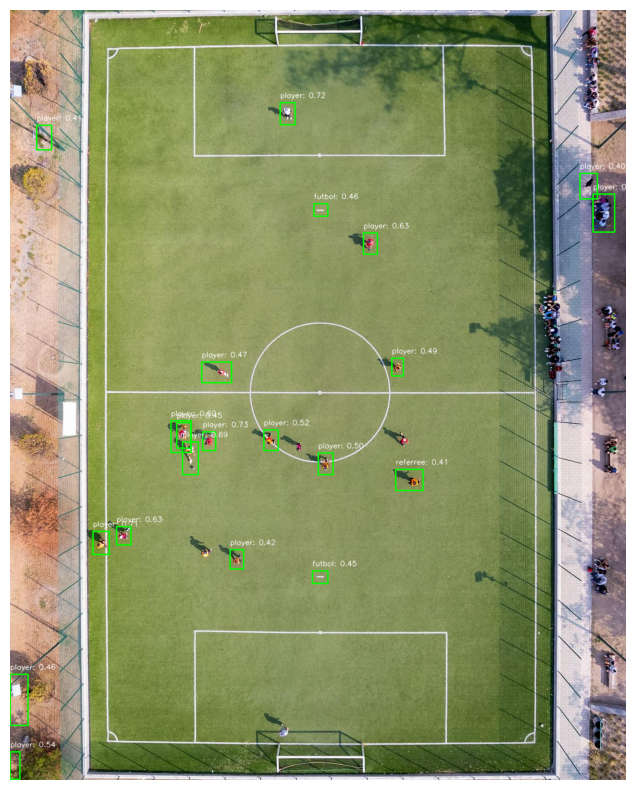

In [14]:
import matplotlib.pyplot as plt

# Load the image (replace with your image loading method)
image = cv2.imread(image_path)

# Bounding boxes, labels, confidence, and label dictionary
bboxes = model_result.prediction.bboxes_xyxy
confidences = model_result.prediction.confidence
labels = model_result.prediction.labels

# Draw bounding boxes and labels on the image
for i in range(len(bboxes)):
    bbox = bboxes[i]
    confidence = confidences[i]
    label = labels[i]
    
    # Coordinates of the bounding box
    x1, y1, x2, y2 = [int(coord) for coord in bbox]

    # Draw the rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

    # Create label text with confidence
    label_text = f"{label_dict[label]}: {confidence:.2f}"

    # Put the label text above the bounding box
    cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.5, color=(255, 255, 255), thickness=1, lineType=cv2.LINE_AA)

# Convert BGR to RGB for displaying in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.imsave("prediction-result.jpg",image_rgb)
plt.axis('off')  # Turn off axis
plt.show()
